# Assessing Autism from Eye Movements Using Deep Learning

**Author:** Tal Alfi  
**Advisor:** Prof. Ohad Ben-Shahar  
**Institution:** Ben-Gurion University of the Negev  

## Project Overview

This notebook implements machine learning and deep learning approaches to:
1. **Classify** children with ASD vs. typically developing controls
2. **Predict severity** of autism symptoms based on ADOS scores

The analysis uses eye-tracking data collected from ~450 children (ages 1–10) watching 90-second social videos.

## 1. Environment Setup and Imports

In [70]:
# Standard libraries
import os
import glob
import warnings
import json
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.graph_objects as go
import plotly.express as px

# Scientific computing
from scipy import stats, signal
from scipy.spatial import distance
from scipy.stats import entropy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Deep Learning (we'll check which framework is available)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    DL_FRAMEWORK = 'pytorch'
    print("Using PyTorch for deep learning")
except ImportError:
    try:
        import tensorflow as tf
        from tensorflow import keras
        DL_FRAMEWORK = 'tensorflow'
        print("Using TensorFlow for deep learning")
    except ImportError:
        DL_FRAMEWORK = None
        print("No deep learning framework found. Install PyTorch or TensorFlow.")

# Set random seeds for reproducibility
np.random.seed(42)
if DL_FRAMEWORK == 'pytorch':
    torch.manual_seed(42)
elif DL_FRAMEWORK == 'tensorflow':
    tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"Python environment setup complete!")
print(f"Available CSV files: {len(glob.glob('files/*.csv'))}")

Using PyTorch for deep learning
Python environment setup complete!
Available CSV files: 7


## 2. Data Loading and Initial Exploration

Let's start by loading one sample file to understand the data structure.

In [71]:
# Get a list of all CSV files
csv_files = sorted(glob.glob('files/*.csv'))
print(f"Found {len(csv_files)} CSV files")
print("\nSample filenames:")
for f in csv_files[:3]:
    print(f"  - {os.path.basename(f)}")

# Load a sample file to explore structure
sample_file = csv_files[0]
print(f"\nLoading sample file: {os.path.basename(sample_file)}")
df_sample = pd.read_csv(sample_file)

print(f"\nDataframe shape: {df_sample.shape}")
print(f"\nColumn names:")
for i, col in enumerate(df_sample.columns):
    print(f"  {i+1:2d}. {col}")

Found 7 CSV files

Sample filenames:
  - 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
  - 1019729632_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
  - 1021745887_unified_eye_metrics_Dinstein_Girls_90_SecX.csv

Loading sample file: 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv

Dataframe shape: (45007, 24)

Column names:
   1. timestamp
   2. frame_number
   3. x_left
   4. y_left
   5. pupil_left
   6. x_right
   7. y_right
   8. pupil_right
   9. input
  10. cr_info
  11. cr_left
  12. cr_right
  13. head_movement_left_x
  14. head_movement_right_x
  15. head_movement_magnitude
  16. inter_pupil_distance
  17. gaze_velocity_left
  18. gaze_velocity_right
  19. is_fixation_left
  20. is_fixation_right
  21. is_saccade_left
  22. is_saccade_right
  23. is_blink_left
  24. is_blink_right


In [72]:
# Display basic info about the data
print("Data shape:", df_sample.shape)
print("\nFirst few rows:")
display(df_sample.head())

# Data types
print("\nData types:")
print(df_sample.dtypes)

Data shape: (45007, 24)

First few rows:


,timestamp,frame_number,x_left,y_left,pupil_left,x_right,y_right,pupil_right,input,cr_info,cr_left,cr_right,head_movement_left_x,head_movement_right_x,head_movement_magnitude,inter_pupil_distance,gaze_velocity_left,gaze_velocity_right,is_fixation_left,is_fixation_right,is_saccade_left,is_saccade_right,is_blink_left,is_blink_right
0,5025592,1,629.3,495.2,735.0,616.4,508.1,708.0,NaN,NaN,5807.0,6408.0,-5177.7,-5791.6,7768.603983,18.243355,250.000000,158.113883,True,True,False,False,False,False
1,5025594,1,629.6,494.8,735.0,616.5,508.4,708.0,NaN,NaN,5807.0,6408.0,-5177.4,-5791.5,7768.329486,18.883061,250.000000,158.113883,True,True,False,False,False,False
2,5025596,1,630.2,494.4,735.0,617.1,508.3,708.0,NaN,NaN,5807.0,6408.0,-5176.8,-5790.9,7767.482285,19.100262,360.555128,304.138127,True,True,False,False,False,False
3,5025598,1,630.8,494.1,734.0,617.6,508.1,708.0,NaN,NaN,5807.0,6408.0,-5176.2,-5790.4,7766.709638,19.241622,335.410197,269.258240,True,True,False,False,False,False
4,5025600,1,631.5,493.8,734.0,618.1,507.9,707.0,NaN,NaN,5807.0,6408.0,-5175.5,-5789.9,7765.870348,19.451735,380.788655,269.258240,True,True,False,False,False,False



Data types:
timestamp                    int64
frame_number                 int64
x_left                     float64
y_left                     float64
pupil_left                 float64
x_right                    float64
y_right                    float64
pupil_right                float64
input                      float64
cr_info                     object
cr_left                    float64
cr_right                   float64
head_movement_left_x       float64
head_movement_right_x      float64
head_movement_magnitude    float64
inter_pupil_distance       float64
gaze_velocity_left         float64
gaze_velocity_right        float64
is_fixation_left              bool
is_fixation_right             bool
is_saccade_left               bool
is_saccade_right              bool
is_blink_left                 bool
is_blink_right                bool
dtype: object


## 3. Data Quality Assessment

In [73]:
# Analyze missing data
missing_percentage = (df_sample.isnull().sum() / len(df_sample)) * 100
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing_Count': df_sample.isnull().sum().values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing data analysis:")
print(missing_df[missing_df['Missing_Percentage'] > 0])

# Identify columns to remove (>95% missing)
cols_to_remove = missing_df[missing_df['Missing_Percentage'] > 95]['Column'].tolist()
print(f"\n❌ Columns to remove (>95% missing): {cols_to_remove}")

# Create cleaned dataframe
df_cleaned = df_sample.drop(columns=cols_to_remove)
print(f"\n✅ Shape after cleaning: {df_sample.shape} → {df_cleaned.shape}")

Missing data analysis:
                     Column  Missing_Count  Missing_Percentage
8                     input          45007          100.000000
9                   cr_info          44171           98.142511
17      gaze_velocity_right            881            1.957473
13    head_movement_right_x            876            1.946364
15     inter_pupil_distance            876            1.946364
5                   x_right            876            1.946364
6                   y_right            876            1.946364
7               pupil_right            876            1.946364
14  head_movement_magnitude            876            1.946364
16       gaze_velocity_left            576            1.279801
12     head_movement_left_x            572            1.270913
4                pupil_left            571            1.268692
3                    y_left            571            1.268692
2                    x_left            571            1.268692
11                 cr_right     

## 4. Understanding Eye-Tracking Columns

In [74]:
# Let's understand the key eye-tracking columns
print("🔍 Key Eye-Tracking Columns:\n")

# Coordinate columns
coord_cols = ['x_left', 'y_left', 'x_right', 'y_right']
print("1. Gaze Coordinates:")
for col in coord_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

# Pupil columns  
print("\n2. Pupil Data:")
pupil_cols = ['pupil_left', 'pupil_right']
for col in pupil_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

# Event columns
print("\n3. Event Detection (binary flags):")
event_cols = ['is_fixation_left', 'is_fixation_right', 'is_saccade_left', 'is_saccade_right', 'is_blink_left', 'is_blink_right']
for col in event_cols:
    print(f"   {col}: unique values = {df_cleaned[col].unique()}")

# Velocity columns
print("\n4. Gaze Velocity:")
vel_cols = ['gaze_velocity_left', 'gaze_velocity_right']
for col in vel_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

🔍 Key Eye-Tracking Columns:

1. Gaze Coordinates:
   x_left: min=-357.90, max=2522.10, missing=571 (1.3%)
   y_left: min=-546.70, max=1839.50, missing=571 (1.3%)
   x_right: min=-860.90, max=2167.00, missing=876 (1.9%)
   y_right: min=-151.30, max=2009.70, missing=876 (1.9%)

2. Pupil Data:
   pupil_left: min=36.00, max=748.00, missing=571 (1.3%)
   pupil_right: min=38.00, max=717.00, missing=876 (1.9%)

3. Event Detection (binary flags):
   is_fixation_left: unique values = [ True False]
   is_fixation_right: unique values = [ True False]
   is_saccade_left: unique values = [False  True]
   is_saccade_right: unique values = [False  True]
   is_blink_left: unique values = [False  True]
   is_blink_right: unique values = [False  True]

4. Gaze Velocity:
   gaze_velocity_left: min=0.00, max=464847.37, missing=576 (1.3%)
   gaze_velocity_right: min=0.00, max=651683.10, missing=881 (2.0%)


## 5. Temporal Analysis - Understanding the Recording

In [75]:
# Let's understand the temporal aspects of the recording
print("📊 Temporal Analysis:")

# Convert timestamp to datetime if needed
df_cleaned['timestamp_dt'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms', errors='coerce')

# Recording duration
duration_ms = df_cleaned['timestamp'].max() - df_cleaned['timestamp'].min()
duration_sec = duration_ms / 1000
print(f"\nRecording duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")

# Sampling rate
time_diffs = df_cleaned['timestamp'].diff().dropna()
mean_interval = time_diffs.mean()
sampling_rate = 1000 / mean_interval  # Hz
print(f"Average sampling rate: {sampling_rate:.2f} Hz")
print(f"Expected samples for 90 seconds at 500Hz: {90 * 500}")
print(f"Actual samples: {len(df_cleaned)}")

# Check if we have the full 90 seconds
if duration_sec < 85:  # Allow some tolerance
    print(f"\n⚠️ Warning: Recording is shorter than expected 90 seconds!")

📊 Temporal Analysis:

Recording duration: 90.01 seconds (1.50 minutes)
Average sampling rate: 500.00 Hz
Expected samples for 90 seconds at 500Hz: 45000
Actual samples: 45007


## 6. Constants

In [76]:
SCREEN_WIDTH = 1280
SCREEN_HEIGHT = 1024
SAMPLING_RATE = 500

## 7. Preprocessing Functions


In [77]:
def add_cleaning_help_features(df_cleaned):
    # Calculate basic quality metrics for visualization
    # Velocity (helps identify saccades, blinks, and tracking errors)
    df_cleaned['velocity_left'] = np.sqrt(
        df_cleaned['x_left'].diff()**2 +
        df_cleaned['y_left'].diff()**2
    ) * SAMPLING_RATE

    df_cleaned['velocity_right'] = np.sqrt(
        df_cleaned['x_right'].diff()**2 +
        df_cleaned['y_right'].diff()**2
    ) * SAMPLING_RATE

    # Binocular disparity (reveals calibration issues)
    df_cleaned['disparity_x'] = df_cleaned['x_left'] - df_cleaned['x_right']
    df_cleaned['disparity_y'] = df_cleaned['y_left'] - df_cleaned['y_right']
    df_cleaned['disparity_total'] = np.sqrt(
        df_cleaned['disparity_x']**2 +
        df_cleaned['disparity_y']**2
    )

    # Data validity flags
    df_cleaned['both_eyes_valid'] = (
        df_cleaned['x_left'].notna() &
        df_cleaned['x_right'].notna()
    )

    # Out of bounds flags
    df_cleaned['left_in_bounds'] = (
        (df_cleaned['x_left'] >= -20) & (df_cleaned['x_left'] <= SCREEN_WIDTH + 20) &
        (df_cleaned['y_left'] >= -20) & (df_cleaned['y_left'] <= SCREEN_HEIGHT + 20)
    )

    df_cleaned['right_in_bounds'] = (
        (df_cleaned['x_right'] >= -20) & (df_cleaned['x_right'] <= SCREEN_WIDTH + 20) &
        (df_cleaned['y_right'] >= -20) & (df_cleaned['y_right'] <= SCREEN_HEIGHT + 20)
    )

    df_cleaned['time_seconds'] = (df_cleaned['timestamp'] - df_cleaned['timestamp'].iloc[0]) / 1000.0

In [78]:
def enforce_binocular_validity(df):
    """
    Enforce binocular data validity: if one eye's data is invalid, 
    mark both eyes as invalid for that sample.
    
    This prevents partial data from creating noise and ensures 
    all analyses use complete binocular information.
    """
    df = df.copy()
    
    # Find samples where only one eye has valid data
    left_valid = df['x_left'].notna() & df['y_left'].notna()
    right_valid = df['x_right'].notna() & df['y_right'].notna()
    
    # Identify monocular samples (only one eye valid)
    monocular_samples = (left_valid & ~right_valid) | (~left_valid & right_valid)
    
    print(f"Found {monocular_samples.sum()} monocular samples ({(monocular_samples.sum()/len(df)*100):.1f}%)")
    
    # Set all coordinate data to NaN for monocular samples
    df.loc[monocular_samples, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
    
    # Also invalidate derived metrics for these samples
    df.loc[monocular_samples, ['pupil_left', 'pupil_right']] = np.nan
    df.loc[monocular_samples, ['is_fixation_left', 'is_fixation_right']] = False
    df.loc[monocular_samples, ['is_saccade_left', 'is_saccade_right']] = False
    
    # Recalculate validity flags
    df['both_eyes_valid'] = df['x_left'].notna() & df['x_right'].notna() & \
                           df['y_left'].notna() & df['y_right'].notna()
    
    print(f"After enforcement: {df['both_eyes_valid'].sum()} valid binocular samples ({(df['both_eyes_valid'].sum()/len(df)*100):.1f}%)")
    
    return df

In [79]:
# automatically corrects small alignment (calibration) errors between the left and right eyes in binocular eye-tracking data.
def automatic_binocular_calibration(df,
                                   velocity_threshold=100,
                                   disparity_percentile=50,
                                   verbose=True):
    df = df.copy()

    # Calculate velocities if not already present
    if 'velocity_left' not in df.columns:
        df['velocity_left'] = np.sqrt(
            df['x_left'].diff()**2 + df['y_left'].diff()**2
        ) * 500  # 500Hz sampling rate

    if 'velocity_right' not in df.columns:
        df['velocity_right'] = np.sqrt(
            df['x_right'].diff()**2 + df['y_right'].diff()**2
        ) * 500

    # Find stable periods (low velocity for both eyes)
    stable_mask = (
        (df['velocity_left'] < velocity_threshold) &
        (df['velocity_right'] < velocity_threshold) &
        df['x_left'].notna() &
        df['x_right'].notna() &
        df['y_left'].notna() &
        df['y_right'].notna()
    )

    stable_samples = stable_mask.sum()

    # Calculate disparities during stable periods
    stable_data = df[stable_mask]
    x_disparity = stable_data['x_left'] - stable_data['x_right']
    y_disparity = stable_data['y_left'] - stable_data['y_right']

    # Calculate robust bias estimates
    x_bias = np.percentile(x_disparity, disparity_percentile)
    y_bias = np.percentile(y_disparity, disparity_percentile)


    # For symmetry, we'll split the correction between both eyes
    x_correction_left = x_bias / 2
    y_correction_left = y_bias / 2
    x_correction_right = -x_bias / 2
    y_correction_right = -y_bias / 2

    # Apply corrections
    df['x_left'] = df['x_left'] - x_correction_left
    df['y_left'] = df['y_left'] - y_correction_left
    df['x_right'] = df['x_right'] - x_correction_right
    df['y_right'] = df['y_right'] - y_correction_right

    # Recalculate disparities with corrected values
    df['disparity_x'] = df['x_left'] - df['x_right']
    df['disparity_y'] = df['y_left'] - df['y_right']
    df['disparity_total'] = np.sqrt(
        df['disparity_x']**2 + df['disparity_y']**2
    )

    # Calculate improvement metrics
    original_disparity = np.sqrt(x_disparity**2 + y_disparity**2).median()
    corrected_disparity = df.loc[stable_mask, 'disparity_total'].median()
    improvement = (1 - corrected_disparity / original_disparity) * 100

    correction_info = {
        'x_bias': x_bias,
        'y_bias': y_bias,
        'stable_samples': stable_samples,
        'original_disparity': original_disparity,
        'corrected_disparity': corrected_disparity,
        'improvement_percent': improvement,
        'x_correction_left': x_correction_left,
        'y_correction_left': y_correction_left,
        'x_correction_right': x_correction_right,
        'y_correction_right': y_correction_right
    }

    if verbose:
        print("🔧 Automatic Binocular Calibration Correction")
        print("=" * 50)
        print(f"Detected biases (based on {stable_samples} stable samples):")
        print(f"  Horizontal: {x_bias:.1f} pixels")
        print(f"  Vertical: {y_bias:.1f} pixels")
        print(f"\nCorrection applied (split between eyes):")
        print(f"  Left eye:  ({x_correction_left:.1f}, {y_correction_left:.1f}) pixels")
        print(f"  Right eye: ({x_correction_right:.1f}, {y_correction_right:.1f}) pixels")
        print(f"\nResults:")
        print(f"  Original disparity: {original_disparity:.1f} pixels")
        print(f"  Corrected disparity: {corrected_disparity:.1f} pixels")
        print(f"  Improvement: {improvement:.1f}%")

    return df, correction_info

In [80]:
def remove_extreme_disparities(df, max_disparity=150):
    """
    Remove samples with physiologically impossible binocular disparities.

    Even if both eyes have valid coordinates, extreme disparities indicate
    tracking errors that should be excluded.

    Args:
        df: DataFrame with eye tracking data
        max_disparity: Maximum allowed disparity in pixels (default 150)
    """
    df = df.copy()

    # Calculate disparity for all samples with both eyes valid
    both_valid = df['both_eyes_valid']

    # Calculate disparity only for valid samples
    df.loc[both_valid, 'disparity_for_filter'] = np.sqrt(
        (df.loc[both_valid, 'x_left'] - df.loc[both_valid, 'x_right'])**2 +
        (df.loc[both_valid, 'y_left'] - df.loc[both_valid, 'y_right'])**2
    )

    # Find extreme disparities
    extreme_mask = both_valid & (df['disparity_for_filter'] > max_disparity)
    n_extreme = extreme_mask.sum()

    print(f"Found {n_extreme} samples with extreme disparity (>{max_disparity} pixels)")
    print(f"That's {n_extreme/both_valid.sum()*100:.2f}% of previously valid data")

    # Invalidate these samples
    df.loc[extreme_mask, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
    df.loc[extreme_mask, ['pupil_left', 'pupil_right']] = np.nan
    df.loc[extreme_mask, 'both_eyes_valid'] = False

    # Also check for out-of-bounds data (way outside screen)
    screen_margin = 500  # pixels
    out_of_bounds = both_valid & (
        (df['x_left'] < -screen_margin) | (df['x_left'] > SCREEN_WIDTH + screen_margin) |
        (df['y_left'] < -screen_margin) | (df['y_left'] > SCREEN_HEIGHT + screen_margin) |
        (df['x_right'] < -screen_margin) | (df['x_right'] > SCREEN_WIDTH + screen_margin) |
        (df['y_right'] < -screen_margin) | (df['y_right'] > SCREEN_HEIGHT + screen_margin)
    )
    n_oob = out_of_bounds.sum()

    print(f"\nFound {n_oob} samples far outside screen bounds (margin={screen_margin}px)")

    # Invalidate out-of-bounds samples
    df.loc[out_of_bounds, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
    df.loc[out_of_bounds, ['pupil_left', 'pupil_right']] = np.nan
    df.loc[out_of_bounds, 'both_eyes_valid'] = False

    # Recalculate validity
    df['both_eyes_valid'] = df['x_left'].notna() & df['x_right'].notna() & \
                           df['y_left'].notna() & df['y_right'].notna()

    print(f"\nAfter filtering: {df['both_eyes_valid'].sum()} valid samples ({df['both_eyes_valid'].sum()/len(df)*100:.1f}%)")

    return df

## 8. Visualization Functions

In [81]:
def plot_trajectory(df_cleaned):
    # Create gaze trajectory plot
    plt.figure(figsize=(10, 8))

    # Get valid data for each eye
    left_valid = df_cleaned.dropna(subset=['x_left', 'y_left'])
    right_valid = df_cleaned.dropna(subset=['x_right', 'y_right'])

    # Plot gaze points
    plt.scatter(left_valid['x_left'], left_valid['y_left'],
               c='blue', alpha=0.3, s=1, label=f'Left eye')
    plt.scatter(right_valid['x_right'], right_valid['y_right'],
               c='red', alpha=0.3, s=1, label=f'Right eye')

    plt.axhline(y=0, color='black', linewidth=2)
    plt.axhline(y=SCREEN_HEIGHT, color='black', linewidth=2)
    plt.axvline(x=0, color='black', linewidth=2)
    plt.axvline(x=SCREEN_WIDTH, color='black', linewidth=2)

    plt.xlim(-200, SCREEN_WIDTH + 200)
    plt.ylim(-200, SCREEN_HEIGHT + 200)
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    plt.title(f'Gaze Trajectory - Subject {os.path.basename(sample_file).split("_")[0]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()

    plt.tight_layout()

    plt.show()

In [82]:
def analyze_binocular_disparity(df, ax=None, title_suffix=""):
    """
    Analyze and visualize binocular disparity over time.
    Modified to work with subplots - can pass an axis object.

    Args:
        df (pd.DataFrame): DataFrame containing at least:
            - 'time_seconds'
            - 'disparity_total'
        ax (matplotlib.axes): Axis to plot on, or None to create new figure
        title_suffix (str): Additional text to add to the title
    """
    if ax is None:
        plt.figure(figsize=(15, 6))
        ax = plt.gca()

    # Plot disparity over time
    ax.plot(df['time_seconds'], df['disparity_total'],
            color='purple', alpha=0.7, linewidth=0.5)
    ax.axhline(y=10, color='green', linestyle='--', label='Good calibration (<10 pixels)')
    ax.axhline(y=30, color='orange', linestyle='--', label='Acceptable (<30 pixels)')
    ax.axhline(y=50, color='red', linestyle='--', label='Poor calibration (>50 pixels)')

    # Highlight high-disparity periods
    high_disparity = df[df['disparity_total'] > 100]
    ax.scatter(high_disparity['time_seconds'], high_disparity['disparity_total'],
               color='red', s=10, alpha=0.5, label='Very high disparity')

    ax.set_ylabel('Binocular Disparity (pixels)')
    ax.set_xlabel('Time (seconds)')
    title = 'Binocular Disparity Throughout Recording'
    if title_suffix:
        title += f' - {title_suffix}'
    ax.set_title(title)
    ax.set_ylim(0, 200)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Calculate statistics to return
    mean_disp = df['disparity_total'].mean()
    median_disp = df['disparity_total'].median()
    percent_over_50 = (df['disparity_total'] > 50).mean() * 100
    percent_over_100 = (df['disparity_total'] > 100).mean() * 100

    stats = {
        'mean_disparity': mean_disp,
        'median_disparity': median_disp,
        'percent_over_50': percent_over_50,
        'percent_over_100': percent_over_100
    }

    return stats

In [83]:
def plot_binocular_disparity_pattern(df, x_col='disparity_x', y_col='disparity_y',
                                    time_col='time_seconds', sample_every=10,
                                    ax=None, title_suffix=""):
    """
    Plot binocular disparity pattern to visualize eye coordination.
    
    Modified to work with subplots - can pass an axis object.
    """
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
    
    # Sample data to avoid overplotting
    sample_data = df[::sample_every].dropna(subset=[x_col, y_col])
    
    # Calculate percentiles to focus on main cluster
    x_5, x_95 = np.percentile(sample_data[x_col], [5, 95])
    y_5, y_95 = np.percentile(sample_data[y_col], [5, 95])
    
    # Create scatter plot
    scatter = ax.scatter(sample_data[x_col], sample_data[y_col],
                        alpha=0.5, s=5, c=sample_data[time_col], cmap='viridis')
    
    # Add reference circles
    for radius, color, label in [(10, 'green', '10 px'),
                                 (30, 'orange', '30 px'),
                                 (50, 'red', '50 px')]:
        circle = plt.Circle((0, 0), radius, fill=False, color=color,
                          linestyle='--', label=label, alpha=0.7)
        ax.add_patch(circle)
    
    # Add center lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    # Labels and title
    ax.set_xlabel('Horizontal Disparity (pixels)')
    ax.set_ylabel('Vertical Disparity (pixels)')
    title = 'Binocular Disparity Pattern'
    if title_suffix:
        title += f' - {title_suffix}'
    ax.set_title(title)
    
    # Focus on main cluster (90% of data)
    margin = 20
    ax.set_xlim(min(x_5 - margin, -100), max(x_95 + margin, 100))
    ax.set_ylim(min(y_5 - margin, -100), max(y_95 + margin, 100))
    
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)
    
    # Return statistics
    stats = {
        'mean_x': sample_data[x_col].mean(),
        'mean_y': sample_data[y_col].mean(),
        'median_x': sample_data[x_col].median(),
        'median_y': sample_data[y_col].median(),
        'x_range': (x_5, x_95),
        'y_range': (y_5, y_95)
    }
    
    return scatter, stats

In [84]:
def extract_and_plot_binocular_saccades(df_cleaned):
    """
    Extract binocular saccades from the data and plot their amplitudes over time.

    Args:
        df_cleaned (pd.DataFrame): DataFrame containing:
            - 'time_seconds', 'x_left', 'y_left', 'x_right', 'y_right'
            - 'is_saccade_left', 'is_saccade_right'

    Returns:
        pd.DataFrame: A DataFrame of detected saccade events.
    """
    saccade_events = []

    in_saccade = False
    saccade_start_x_left = None
    saccade_start_y_left = None
    saccade_start_x_right = None
    saccade_start_y_right = None
    saccade_start_time = None

    for idx, row in df_cleaned.iterrows():
        both_eyes_saccade = (row['is_saccade_left'] == True) and (row['is_saccade_right'] == True)

        if both_eyes_saccade and not in_saccade:
            in_saccade = True
            saccade_start_x_left = row['x_left']
            saccade_start_y_left = row['y_left']
            saccade_start_x_right = row['x_right']
            saccade_start_y_right = row['y_right']
            saccade_start_time = row['time_seconds']

        elif not both_eyes_saccade and in_saccade:
            if pd.notna(saccade_start_x_left) and pd.notna(row['x_left']) and \
               pd.notna(saccade_start_x_right) and pd.notna(row['x_right']):

                distance_left = np.sqrt((row['x_left'] - saccade_start_x_left) ** 2 +
                                        (row['y_left'] - saccade_start_y_left) ** 2)
                distance_right = np.sqrt((row['x_right'] - saccade_start_x_right) ** 2 +
                                         (row['y_right'] - saccade_start_y_right) ** 2)

                avg_distance = (distance_left + distance_right) / 2
                duration = row['time_seconds'] - saccade_start_time

                saccade_events.append({
                    'start_time': saccade_start_time,
                    'end_time': row['time_seconds'],
                    'duration_ms': duration * 1000,
                    'amplitude_pixels': avg_distance,
                    'amplitude_left': distance_left,
                    'amplitude_right': distance_right,
                    'amplitude_difference': abs(distance_left - distance_right),
                    'start_x_left': saccade_start_x_left,
                    'start_y_left': saccade_start_y_left,
                    'end_x_left': row['x_left'],
                    'end_y_left': row['y_left']
                })

            in_saccade = False

    saccades_df = pd.DataFrame(saccade_events)

    print(f"Total binocular saccades detected: {len(saccades_df)}")
    if len(saccades_df) > 0:
        print(f"Average saccade amplitude: {saccades_df['amplitude_pixels'].mean():.1f} pixels")
        print(f"Average saccade duration: {saccades_df['duration_ms'].mean():.1f} ms")
        print(f"Average amplitude difference between eyes: {saccades_df['amplitude_difference'].mean():.1f} pixels")

        plt.figure(figsize=(15, 6))
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_pixels'],
                    alpha=0.6, s=20, c='darkblue', label='Average amplitude')
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_left'],
                    alpha=0.3, s=10, c='blue', label='Left eye')
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_right'],
                    alpha=0.3, s=10, c='red', label='Right eye')

        plt.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Small saccade')
        plt.axhline(y=500, color='orange', linestyle='--', alpha=0.5, label='Medium saccade')
        plt.axhline(y=1000, color='red', linestyle='--', alpha=0.5, label='Large saccade')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Saccade Amplitude (pixels)')
        plt.title('Binocular Saccade Amplitudes Throughout 90-Second Recording')
        plt.xlim(0, 90)
        plt.ylim(0, saccades_df['amplitude_pixels'].quantile(0.95) * 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No binocular saccades found in the data.")

    return saccades_df

## 8. Apply Preprocessing Pipeline

Now let's apply all the preprocessing steps in the correct order:

In [85]:
# Step 1: Add helper features for cleaning
print("Step 1: Adding helper features...")
add_cleaning_help_features(df_cleaned)
print("✓ Helper features added\n")

Step 1: Adding helper features...
✓ Helper features added



In [86]:
# Step 2: Enforce binocular validity
print("Step 2: Enforcing binocular validity...")
df_binocular = enforce_binocular_validity(df_cleaned)
print("✓ Binocular validity enforced\n")

Step 2: Enforcing binocular validity...
Found 305 monocular samples (0.7%)
After enforcement: 44131 valid binocular samples (98.1%)
✓ Binocular validity enforced



In [87]:
# Step 3: Apply automatic binocular calibration
print("Step 3: Applying automatic binocular calibration...")
df_corrected, correction_info = automatic_binocular_calibration(df_binocular)
print("✓ Binocular calibration applied\n")

Step 3: Applying automatic binocular calibration...
🔧 Automatic Binocular Calibration Correction
Detected biases (based on 113 stable samples):
  Horizontal: -1.0 pixels
  Vertical: -17.7 pixels

Correction applied (split between eyes):
  Left eye:  (-0.5, -8.8) pixels
  Right eye: (0.5, 8.8) pixels

Results:
  Original disparity: 24.3 pixels
  Corrected disparity: 21.5 pixels
  Improvement: 11.5%
✓ Binocular calibration applied



In [88]:
# Step 4: Remove extreme disparities
print("Step 4: Removing extreme disparities...")
df_final = remove_extreme_disparities(df_corrected, max_disparity=150)
print("✓ Extreme disparities removed\n")

# Summary
print("\n📊 Complete Preprocessing Summary:")
print("="*50)
print(f"Original samples: {len(df_sample):,}")
print(f"After removing empty columns: {len(df_cleaned):,}")
print(f"After binocular enforcement: {df_binocular['both_eyes_valid'].sum():,}")
print(f"After calibration correction: {len(df_corrected):,}")
print(f"Final clean samples: {df_final['both_eyes_valid'].sum():,}")
print(f"\nData retention: {df_final['both_eyes_valid'].sum()/len(df_sample)*100:.1f}%")

Step 4: Removing extreme disparities...
Found 696 samples with extreme disparity (>150 pixels)
That's 1.58% of previously valid data

Found 0 samples far outside screen bounds (margin=500px)

After filtering: 43435 valid samples (96.5%)
✓ Extreme disparities removed


📊 Complete Preprocessing Summary:
Original samples: 45,007
After removing empty columns: 45,007
After binocular enforcement: 44,131
After calibration correction: 45,007
Final clean samples: 43,435

Data retention: 96.5%


## 9. Visualize Preprocessing Results
## 6. Constants Definition

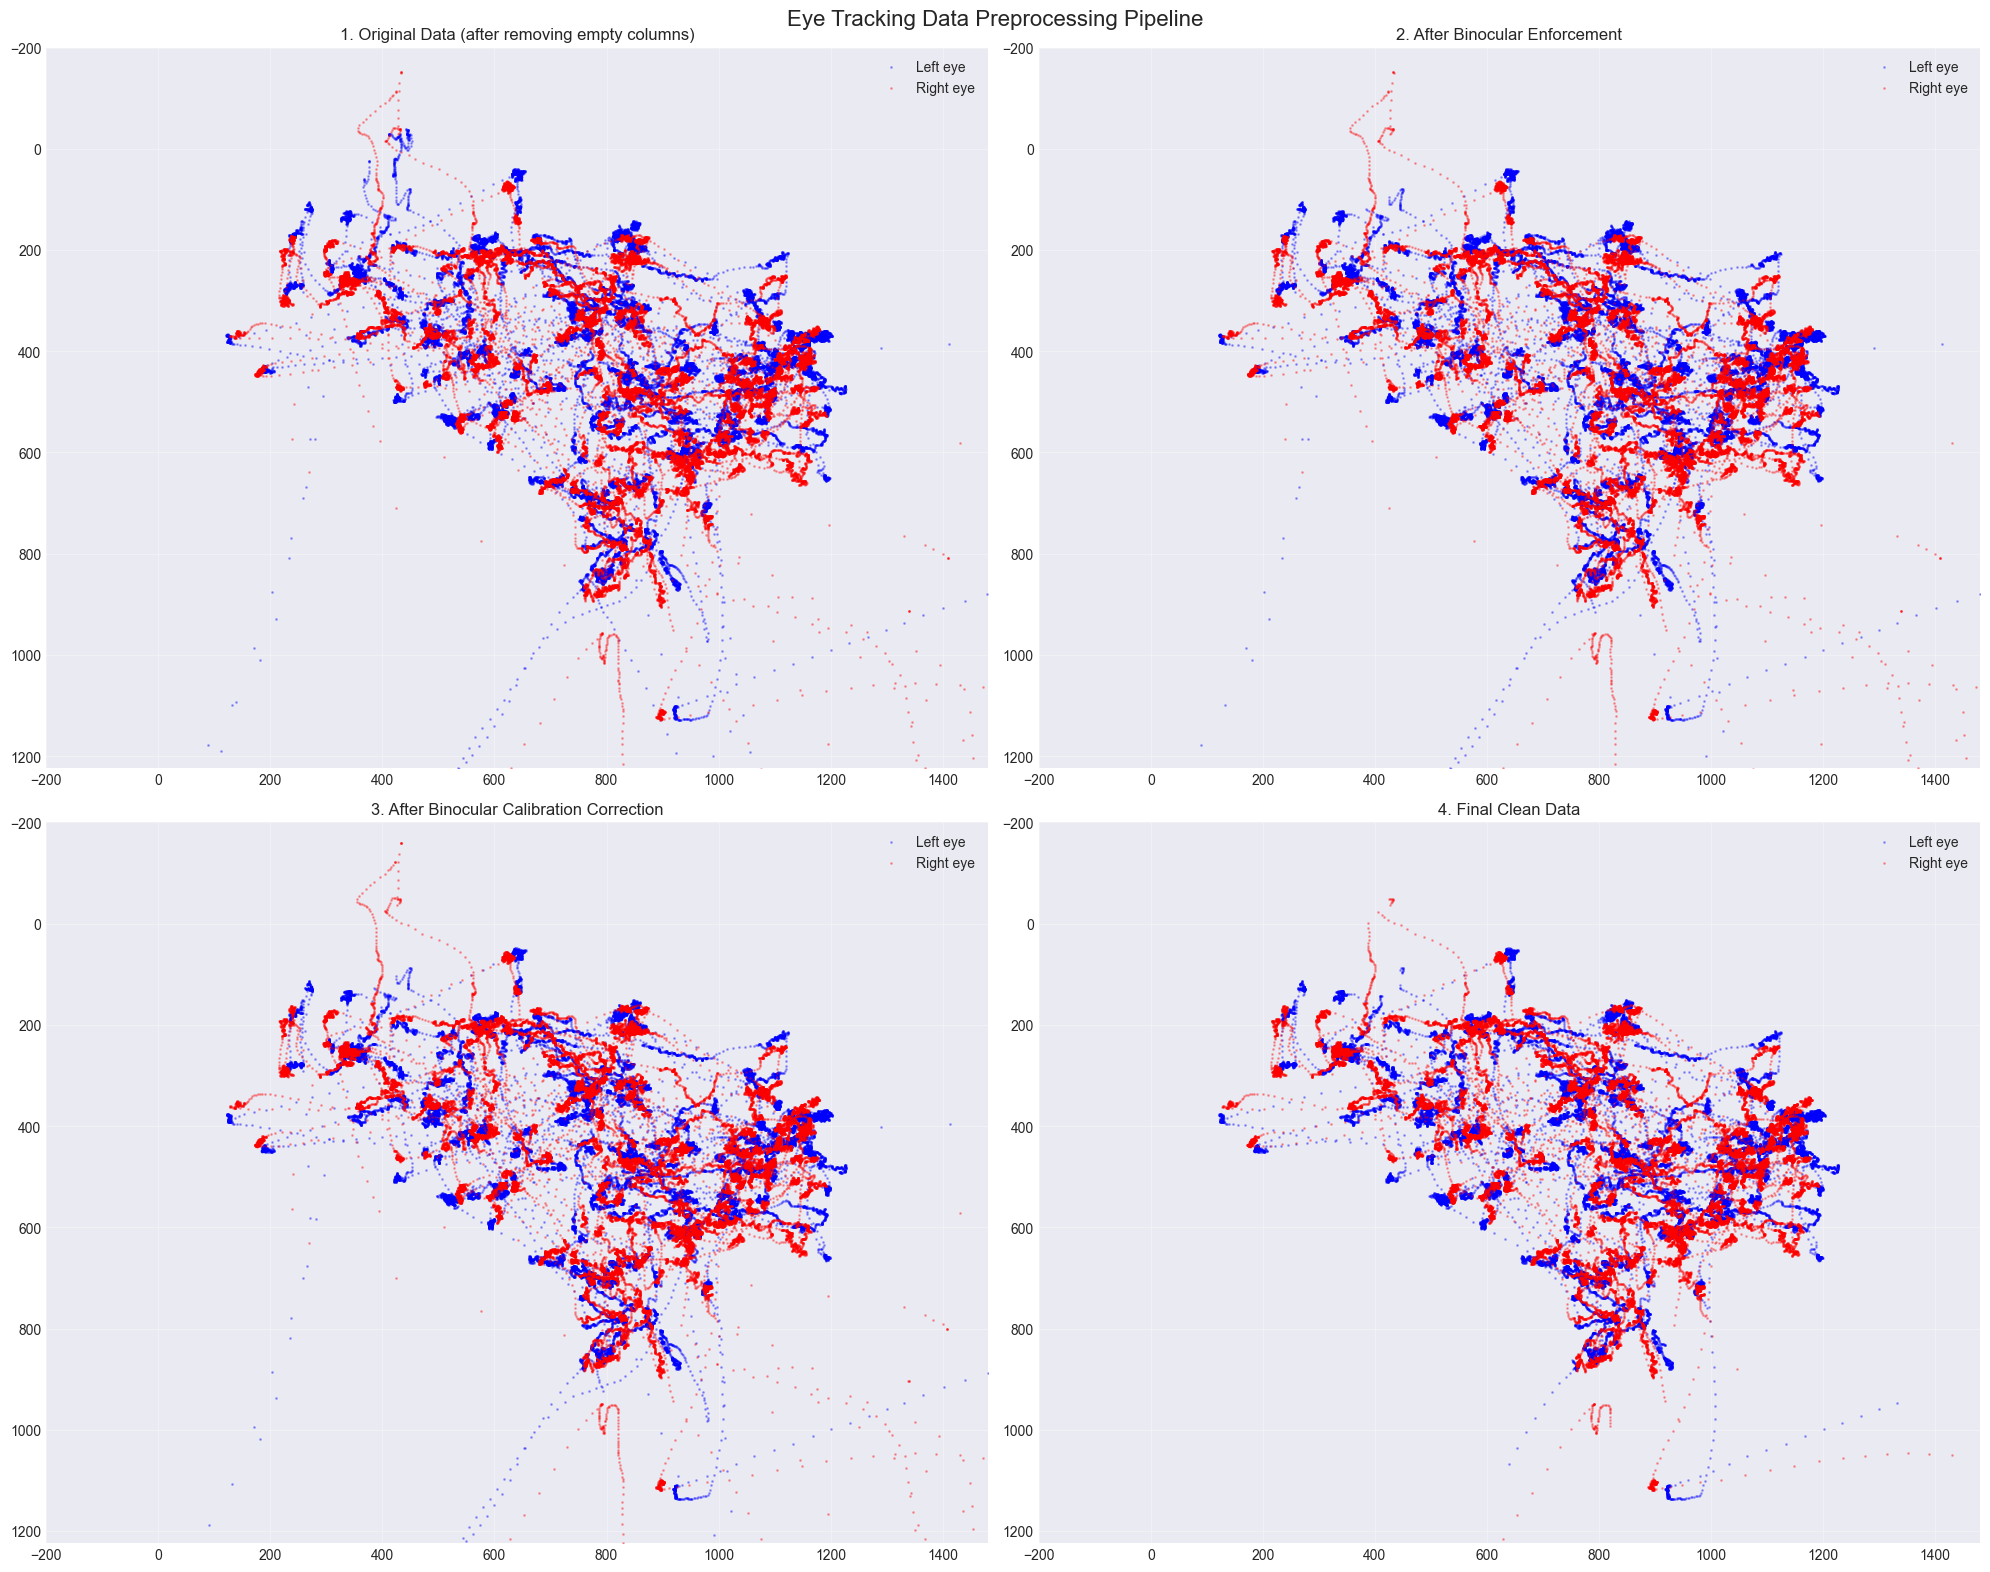

In [89]:
# Visualize the preprocessing pipeline results
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Original data
ax = axes[0, 0]
ax.scatter(df_cleaned['x_left'], df_cleaned['y_left'], c='blue', alpha=0.3, s=1, label='Left eye')
ax.scatter(df_cleaned['x_right'], df_cleaned['y_right'], c='red', alpha=0.3, s=1, label='Right eye')
ax.set_title('1. Original Data (after removing empty columns)')
ax.set_xlim(-200, SCREEN_WIDTH + 200)
ax.set_ylim(-200, SCREEN_HEIGHT + 200)
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3)

# 2. After binocular enforcement
ax = axes[0, 1]
valid_data = df_binocular[df_binocular['both_eyes_valid']]
ax.scatter(valid_data['x_left'], valid_data['y_left'], c='blue', alpha=0.3, s=1, label='Left eye')
ax.scatter(valid_data['x_right'], valid_data['y_right'], c='red', alpha=0.3, s=1, label='Right eye')
ax.set_title('2. After Binocular Enforcement')
ax.set_xlim(-200, SCREEN_WIDTH + 200)
ax.set_ylim(-200, SCREEN_HEIGHT + 200)
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3)

# 3. After calibration correction
ax = axes[1, 0]
valid_data = df_corrected[df_corrected['both_eyes_valid']]
ax.scatter(valid_data['x_left'], valid_data['y_left'], c='blue', alpha=0.3, s=1, label='Left eye')
ax.scatter(valid_data['x_right'], valid_data['y_right'], c='red', alpha=0.3, s=1, label='Right eye')
ax.set_title('3. After Binocular Calibration Correction')
ax.set_xlim(-200, SCREEN_WIDTH + 200)
ax.set_ylim(-200, SCREEN_HEIGHT + 200)
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Final clean data
ax = axes[1, 1]
valid_data = df_final[df_final['both_eyes_valid']]
ax.scatter(valid_data['x_left'], valid_data['y_left'], c='blue', alpha=0.3, s=1, label='Left eye')
ax.scatter(valid_data['x_right'], valid_data['y_right'], c='red', alpha=0.3, s=1, label='Right eye')
ax.set_title('4. Final Clean Data')
ax.set_xlim(-200, SCREEN_WIDTH + 200)
ax.set_ylim(-200, SCREEN_HEIGHT + 200)
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Eye Tracking Data Preprocessing Pipeline', fontsize=16)
plt.tight_layout()
plt.show()

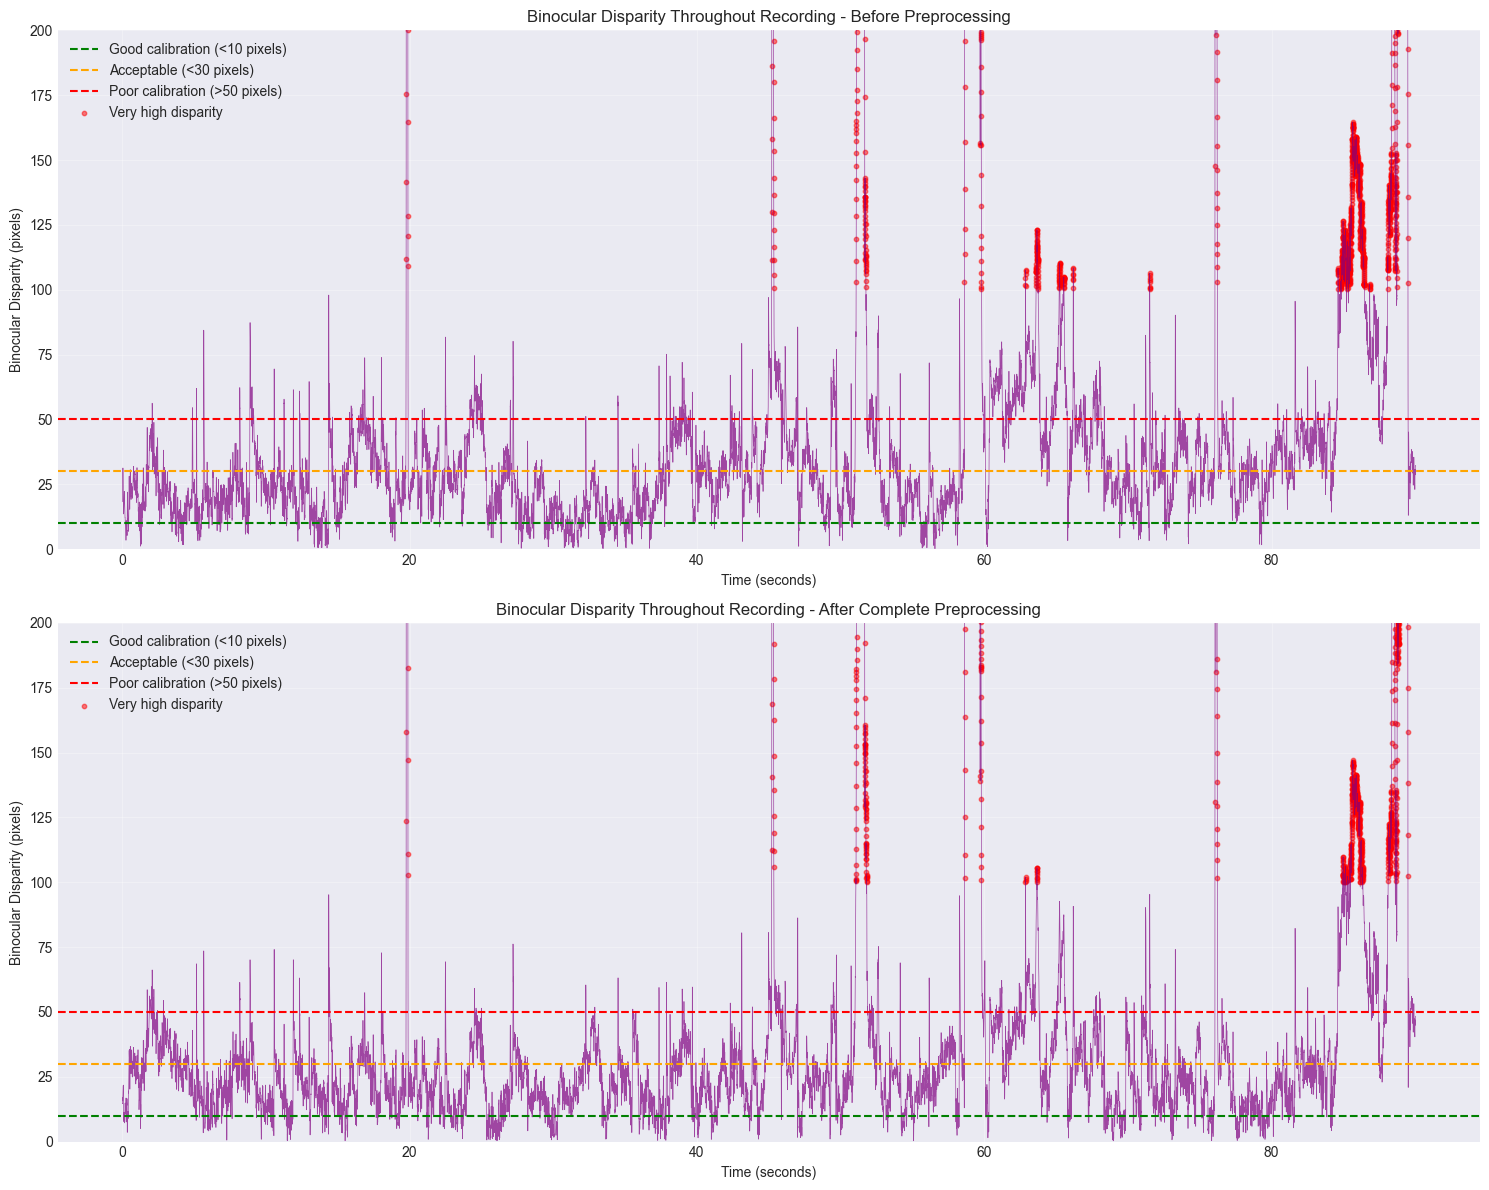


Disparity Improvement:
Mean disparity: 39.7 → 34.0 pixels
Reduction: 14.3%


In [90]:
# Analyze binocular disparity before and after preprocessing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Before preprocessing
stats_before = analyze_binocular_disparity(df_cleaned, ax=ax1, title_suffix="Before Preprocessing")

# After preprocessing
stats_after = analyze_binocular_disparity(df_final, ax=ax2, title_suffix="After Complete Preprocessing")

plt.tight_layout()
plt.show()

# Print improvement
print("\nDisparity Improvement:")
print(f"Mean disparity: {stats_before['mean_disparity']:.1f} → {stats_after['mean_disparity']:.1f} pixels")
print(f"Reduction: {((stats_before['mean_disparity'] - stats_after['mean_disparity']) / stats_before['mean_disparity'] * 100):.1f}%")

Total binocular saccades detected: 132
Average saccade amplitude: 219.4 pixels
Average saccade duration: 32.2 ms
Average amplitude difference between eyes: 19.6 pixels


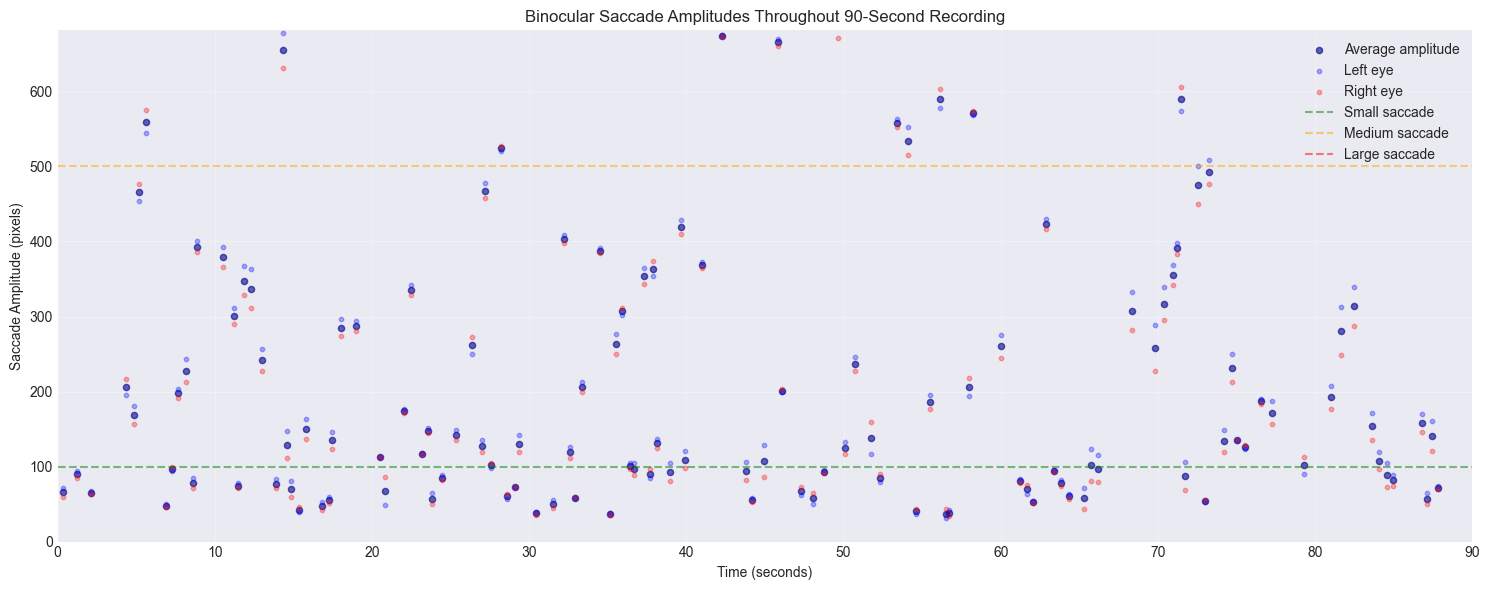

In [91]:
# Extract and visualize saccades from the clean data
saccades_df = extract_and_plot_binocular_saccades(df_final)

## 10. Additional Preprocessing Functions

Based on the preprocessing requirements, let's implement the remaining steps:

In [92]:
def detect_and_handle_blinks(df, gap_threshold=5, blink_window=24, verbose=True):
    """
    Detect and handle blinks in eye-tracking data.
    
    Technical gaps (>5 samples) are marked as NaN.
    Natural blinks (up to 24 samples) are interpolated.
    
    Args:
        df: DataFrame with eye tracking data
        gap_threshold: Samples to consider as technical gap (default 5)
        blink_window: Maximum samples for natural blink (default 24 = ~48ms at 500Hz)
        verbose: Print progress info
    
    Returns:
        df: DataFrame with blinks handled
        blink_stats: Dictionary with blink statistics
    """
    df = df.copy()
    
    # Initialize blink detection columns if not present
    if 'is_blink_left' not in df.columns:
        df['is_blink_left'] = False
    if 'is_blink_right' not in df.columns:
        df['is_blink_right'] = False
    
    # Detect missing data periods for each eye
    left_missing = df['x_left'].isna() | df['y_left'].isna()
    right_missing = df['x_right'].isna() | df['y_right'].isna()
    
    # Function to find consecutive missing periods
    def find_missing_periods(missing_mask):
        periods = []
        in_period = False
        start_idx = 0
        
        for i, is_missing in enumerate(missing_mask):
            if is_missing and not in_period:
                start_idx = i
                in_period = True
            elif not is_missing and in_period:
                periods.append((start_idx, i - 1))
                in_period = False
        
        # Handle case where data ends during missing period
        if in_period:
            periods.append((start_idx, len(missing_mask) - 1))
        
        return periods
    
    # Find missing periods for each eye
    left_periods = find_missing_periods(left_missing)
    right_periods = find_missing_periods(right_missing)
    
    # Process left eye
    technical_gaps_left = 0
    natural_blinks_left = 0
    interpolated_samples_left = 0
    
    for start, end in left_periods:
        duration = end - start + 1
        
        if duration > gap_threshold and duration <= blink_window:
            # Natural blink - interpolate
            if start > 0 and end < len(df) - 1:
                # Linear interpolation for coordinates
                df.loc[start:end, 'x_left'] = np.interp(
                    np.arange(start, end + 1),
                    [start - 1, end + 1],
                    [df.loc[start - 1, 'x_left'], df.loc[end + 1, 'x_left']]
                )
                df.loc[start:end, 'y_left'] = np.interp(
                    np.arange(start, end + 1),
                    [start - 1, end + 1],
                    [df.loc[start - 1, 'y_left'], df.loc[end + 1, 'y_left']]
                )
                # Mark as blink
                df.loc[start:end, 'is_blink_left'] = True
                natural_blinks_left += 1
                interpolated_samples_left += duration
        elif duration > blink_window:
            # Technical gap - keep as NaN
            technical_gaps_left += 1
    
    # Process right eye
    technical_gaps_right = 0
    natural_blinks_right = 0
    interpolated_samples_right = 0
    
    for start, end in right_periods:
        duration = end - start + 1
        
        if duration > gap_threshold and duration <= blink_window:
            # Natural blink - interpolate
            if start > 0 and end < len(df) - 1:
                # Linear interpolation for coordinates
                df.loc[start:end, 'x_right'] = np.interp(
                    np.arange(start, end + 1),
                    [start - 1, end + 1],
                    [df.loc[start - 1, 'x_right'], df.loc[end + 1, 'x_right']]
                )
                df.loc[start:end, 'y_right'] = np.interp(
                    np.arange(start, end + 1),
                    [start - 1, end + 1],
                    [df.loc[start - 1, 'y_right'], df.loc[end + 1, 'y_right']]
                )
                # Mark as blink
                df.loc[start:end, 'is_blink_right'] = True
                natural_blinks_right += 1
                interpolated_samples_right += duration
        elif duration > blink_window:
            # Technical gap - keep as NaN
            technical_gaps_right += 1
    
    # Update binocular validity
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    blink_stats = {
        'left_eye': {
            'technical_gaps': technical_gaps_left,
            'natural_blinks': natural_blinks_left,
            'interpolated_samples': interpolated_samples_left
        },
        'right_eye': {
            'technical_gaps': technical_gaps_right,
            'natural_blinks': natural_blinks_right,
            'interpolated_samples': interpolated_samples_right
        }
    }
    
    if verbose:
        print("👁️ Blink Detection and Handling")
        print("=" * 50)
        print(f"Left eye:")
        print(f"  Technical gaps: {technical_gaps_left}")
        print(f"  Natural blinks: {natural_blinks_left} ({interpolated_samples_left} samples interpolated)")
        print(f"Right eye:")
        print(f"  Technical gaps: {technical_gaps_right}")
        print(f"  Natural blinks: {natural_blinks_right} ({interpolated_samples_right} samples interpolated)")
        print(f"\nTotal blink periods marked: {df['is_blink_left'].sum()} (left), {df['is_blink_right'].sum()} (right)")
    
    return df, blink_stats

In [93]:
def round_coordinates_to_pixels(df, verbose=True):
    """
    Round eye position values to whole numbers (integer pixels).
    This removes sub-pixel noise and makes the format consistent.
    
    Args:
        df: DataFrame with eye tracking data
        verbose: Print progress info
    
    Returns:
        df: DataFrame with rounded coordinates
    """
    df = df.copy()
    
    # Columns to round
    coord_columns = ['x_left', 'y_left', 'x_right', 'y_right']
    
    # Calculate precision before rounding
    precision_stats = {}
    for col in coord_columns:
        if col in df.columns:
            valid_data = df[col].dropna()
            if len(valid_data) > 0:
                # Calculate decimal places
                decimals = valid_data.apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
                precision_stats[col] = {
                    'mean_decimals': decimals.mean(),
                    'max_decimals': decimals.max(),
                    'samples_with_decimals': (decimals > 0).sum()
                }
    
    # Round coordinates
    for col in coord_columns:
        if col in df.columns:
            df[col] = df[col].round().astype('Int64')  # Use nullable integer type
    
    if verbose:
        print("🎯 Coordinate Rounding to Integer Pixels")
        print("=" * 50)
        for col, stats in precision_stats.items():
            print(f"{col}:")
            print(f"  Average decimal places: {stats['mean_decimals']:.2f}")
            print(f"  Samples with decimals: {stats['samples_with_decimals']:,} ({stats['samples_with_decimals']/len(df)*100:.1f}%)")
        print("\n✓ All coordinates rounded to nearest pixel")
    
    return df

In [94]:
def preprocess_pupil_size(df, min_pupil=200, max_pupil=1200, window_size=250, verbose=True):
    """
    Preprocess pupil size data by removing implausible values and smoothing.
    
    Args:
        df: DataFrame with eye tracking data
        min_pupil: Minimum plausible pupil size (default 200)
        max_pupil: Maximum plausible pupil size (default 1200)
        window_size: Gaussian smoothing window size in samples (default 250 = 500ms at 500Hz)
        verbose: Print progress info
    
    Returns:
        df: DataFrame with preprocessed pupil data
        pupil_stats: Dictionary with pupil preprocessing statistics
    """
    df = df.copy()
    
    pupil_columns = ['pupil_left', 'pupil_right']
    pupil_stats = {}
    
    for col in pupil_columns:
        if col not in df.columns:
            continue
            
        original_data = df[col].copy()
        
        # Count implausible values
        zero_pupils = (original_data == 0).sum()
        too_small = ((original_data > 0) & (original_data < min_pupil)).sum()
        too_large = (original_data > max_pupil).sum()
        
        # Remove implausible values
        df.loc[(df[col] == 0) | (df[col] < min_pupil) | (df[col] > max_pupil), col] = np.nan
        
        # Exclude first second (500 samples) - adaptation period
        if len(df) > 500:
            df.loc[:499, col] = np.nan
            adaptation_removed = 500
        else:
            adaptation_removed = 0
        
        # Detect and remove sharp changes (likely artifacts)
        if df[col].notna().sum() > 10:  # Need enough data
            # Calculate derivative
            pupil_diff = df[col].diff().abs()
            
            # Find threshold for sharp changes (e.g., 99th percentile)
            threshold = pupil_diff.quantile(0.99)
            sharp_changes = pupil_diff > threshold
            sharp_change_count = sharp_changes.sum()
            
            # Remove samples with sharp changes
            df.loc[sharp_changes, col] = np.nan
        else:
            sharp_change_count = 0
        
        # Apply Gaussian smoothing to remaining valid data
        valid_mask = df[col].notna()
        if valid_mask.sum() > window_size:
            # Create a copy for smoothing
            smoothed_data = df[col].copy()
            
            # Apply Gaussian filter only to valid data
            from scipy.ndimage import gaussian_filter1d
            valid_indices = np.where(valid_mask)[0]
            valid_values = df.loc[valid_mask, col].values
            
            # Apply smoothing
            sigma = window_size / 4  # Standard deviation for Gaussian
            smoothed_values = gaussian_filter1d(valid_values, sigma=sigma, mode='nearest')
            
            # Put smoothed values back
            smoothed_data.iloc[valid_indices] = smoothed_values
            df[col] = smoothed_data
        
        # Calculate statistics
        final_valid = df[col].notna().sum()
        original_valid = original_data.notna().sum()
        
        pupil_stats[col] = {
            'original_valid': original_valid,
            'zero_pupils': zero_pupils,
            'too_small': too_small,
            'too_large': too_large,
            'adaptation_removed': adaptation_removed,
            'sharp_changes': sharp_change_count,
            'final_valid': final_valid,
            'removed_total': original_valid - final_valid,
            'removal_percentage': (original_valid - final_valid) / original_valid * 100 if original_valid > 0 else 0
        }
    
    if verbose:
        print("👁️ Pupil Size Preprocessing")
        print("=" * 50)
        for col, stats in pupil_stats.items():
            print(f"\n{col}:")
            print(f"  Original valid samples: {stats['original_valid']:,}")
            print(f"  Removed:")
            print(f"    - Zero values: {stats['zero_pupils']}")
            print(f"    - Too small (<{min_pupil}): {stats['too_small']}")
            print(f"    - Too large (>{max_pupil}): {stats['too_large']}")
            print(f"    - First second (adaptation): {stats['adaptation_removed']}")
            print(f"    - Sharp changes: {stats['sharp_changes']}")
            print(f"  Final valid samples: {stats['final_valid']:,} ({stats['removal_percentage']:.1f}% removed)")
            print(f"  ✓ Gaussian smoothing applied (window={window_size} samples)")
    
    return df, pupil_stats

## 11. Complete Preprocessing Pipeline

Now let's create a comprehensive preprocessing function that includes all steps:

In [95]:
def complete_preprocessing_pipeline(file_path, verbose=True):
    """
    Complete preprocessing pipeline for eye-tracking data including all steps.
    
    Processing steps:
    1. Load data and remove empty columns
    2. Add helper features
    3. Detect and handle blinks (interpolation)
    4. Enforce binocular validity
    5. Apply automatic binocular calibration
    6. Remove extreme disparities
    7. Round coordinates to integer pixels
    8. Preprocess pupil size data
    
    Args:
        file_path: Path to CSV file
        verbose: Print progress messages
    
    Returns:
        df_final: Fully preprocessed dataframe
        preprocessing_info: Dictionary with all preprocessing statistics
    """
    if verbose:
        print(f"\n🚀 Complete Preprocessing Pipeline")
        print(f"File: {os.path.basename(file_path)}")
        print("="*60)
    
    # Step 1: Load data
    df = pd.read_csv(file_path)
    initial_samples = len(df)
    
    # Remove empty columns
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    cols_to_remove = missing_percentage[missing_percentage > 95].index.tolist()
    df = df.drop(columns=cols_to_remove)
    
    if verbose:
        print(f"✓ Step 1: Loaded data ({initial_samples:,} samples)")
        print(f"         Removed {len(cols_to_remove)} empty columns")
    
    # Step 2: Add helper features
    add_cleaning_help_features(df)
    if verbose:
        print("✓ Step 2: Added helper features")
    
    # Step 3: Detect and handle blinks
    df, blink_stats = detect_and_handle_blinks(df, verbose=False)
    if verbose:
        total_blinks = (blink_stats['left_eye']['natural_blinks'] + 
                       blink_stats['right_eye']['natural_blinks'])
        print(f"✓ Step 3: Handled blinks ({total_blinks} natural blinks interpolated)")
    
    # Step 4: Enforce binocular validity
    df = enforce_binocular_validity(df)
    binocular_samples = df['both_eyes_valid'].sum()
    if verbose:
        print(f"✓ Step 4: Enforced binocular validity ({binocular_samples:,} valid samples)")
    
    # Step 5: Apply calibration correction
    df, correction_info = automatic_binocular_calibration(df, verbose=False)
    if verbose:
        print(f"✓ Step 5: Applied binocular calibration (improved by {correction_info['improvement_percent']:.1f}%)")
    
    # Step 6: Remove extreme disparities
    df = remove_extreme_disparities(df, max_disparity=150)
    valid_after_disparity = df['both_eyes_valid'].sum()
    if verbose:
        print(f"✓ Step 6: Removed extreme disparities ({valid_after_disparity:,} valid samples)")
    
    # Step 7: Round coordinates to pixels
    df = round_coordinates_to_pixels(df, verbose=False)
    if verbose:
        print("✓ Step 7: Rounded coordinates to integer pixels")
    
    # Step 8: Preprocess pupil size
    df, pupil_stats = preprocess_pupil_size(df, verbose=False)
    if verbose:
        print("✓ Step 8: Preprocessed pupil size data")
    
    # Calculate final statistics
    final_valid_samples = df['both_eyes_valid'].sum()
    
    preprocessing_info = {
        'file': os.path.basename(file_path),
        'initial_samples': initial_samples,
        'final_valid_samples': final_valid_samples,
        'retention_rate': final_valid_samples / initial_samples * 100,
        'blink_stats': blink_stats,
        'calibration_correction': correction_info,
        'pupil_stats': pupil_stats,
        'steps': {
            'after_blinks': len(df),
            'after_binocular': binocular_samples,
            'after_calibration': len(df),
            'after_disparity': valid_after_disparity,
            'final': final_valid_samples
        }
    }
    
    if verbose:
        print("\n" + "="*60)
        print(f"📊 Final Summary:")
        print(f"   Initial samples: {initial_samples:,}")
        print(f"   Final valid samples: {final_valid_samples:,}")
        print(f"   Data retention: {preprocessing_info['retention_rate']:.1f}%")
        print("="*60)
    
    return df, preprocessing_info

## 12. Test Complete Pipeline

In [96]:
# Test the complete pipeline on one file
df_processed, info = complete_preprocessing_pipeline(csv_files[0])


🚀 Complete Preprocessing Pipeline
File: 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
✓ Step 1: Loaded data (45,007 samples)
         Removed 2 empty columns
✓ Step 2: Added helper features
✓ Step 3: Handled blinks (3 natural blinks interpolated)
Found 275 monocular samples (0.6%)
After enforcement: 44173 valid binocular samples (98.1%)
✓ Step 4: Enforced binocular validity (44,173 valid samples)
✓ Step 5: Applied binocular calibration (improved by 11.5%)
Found 731 samples with extreme disparity (>150 pixels)
That's 1.65% of previously valid data

Found 7 samples far outside screen bounds (margin=500px)

After filtering: 43435 valid samples (96.5%)
✓ Step 6: Removed extreme disparities (43,435 valid samples)
✓ Step 7: Rounded coordinates to integer pixels
✓ Step 8: Preprocessed pupil size data

📊 Final Summary:
   Initial samples: 45,007
   Final valid samples: 43,435
   Data retention: 96.5%


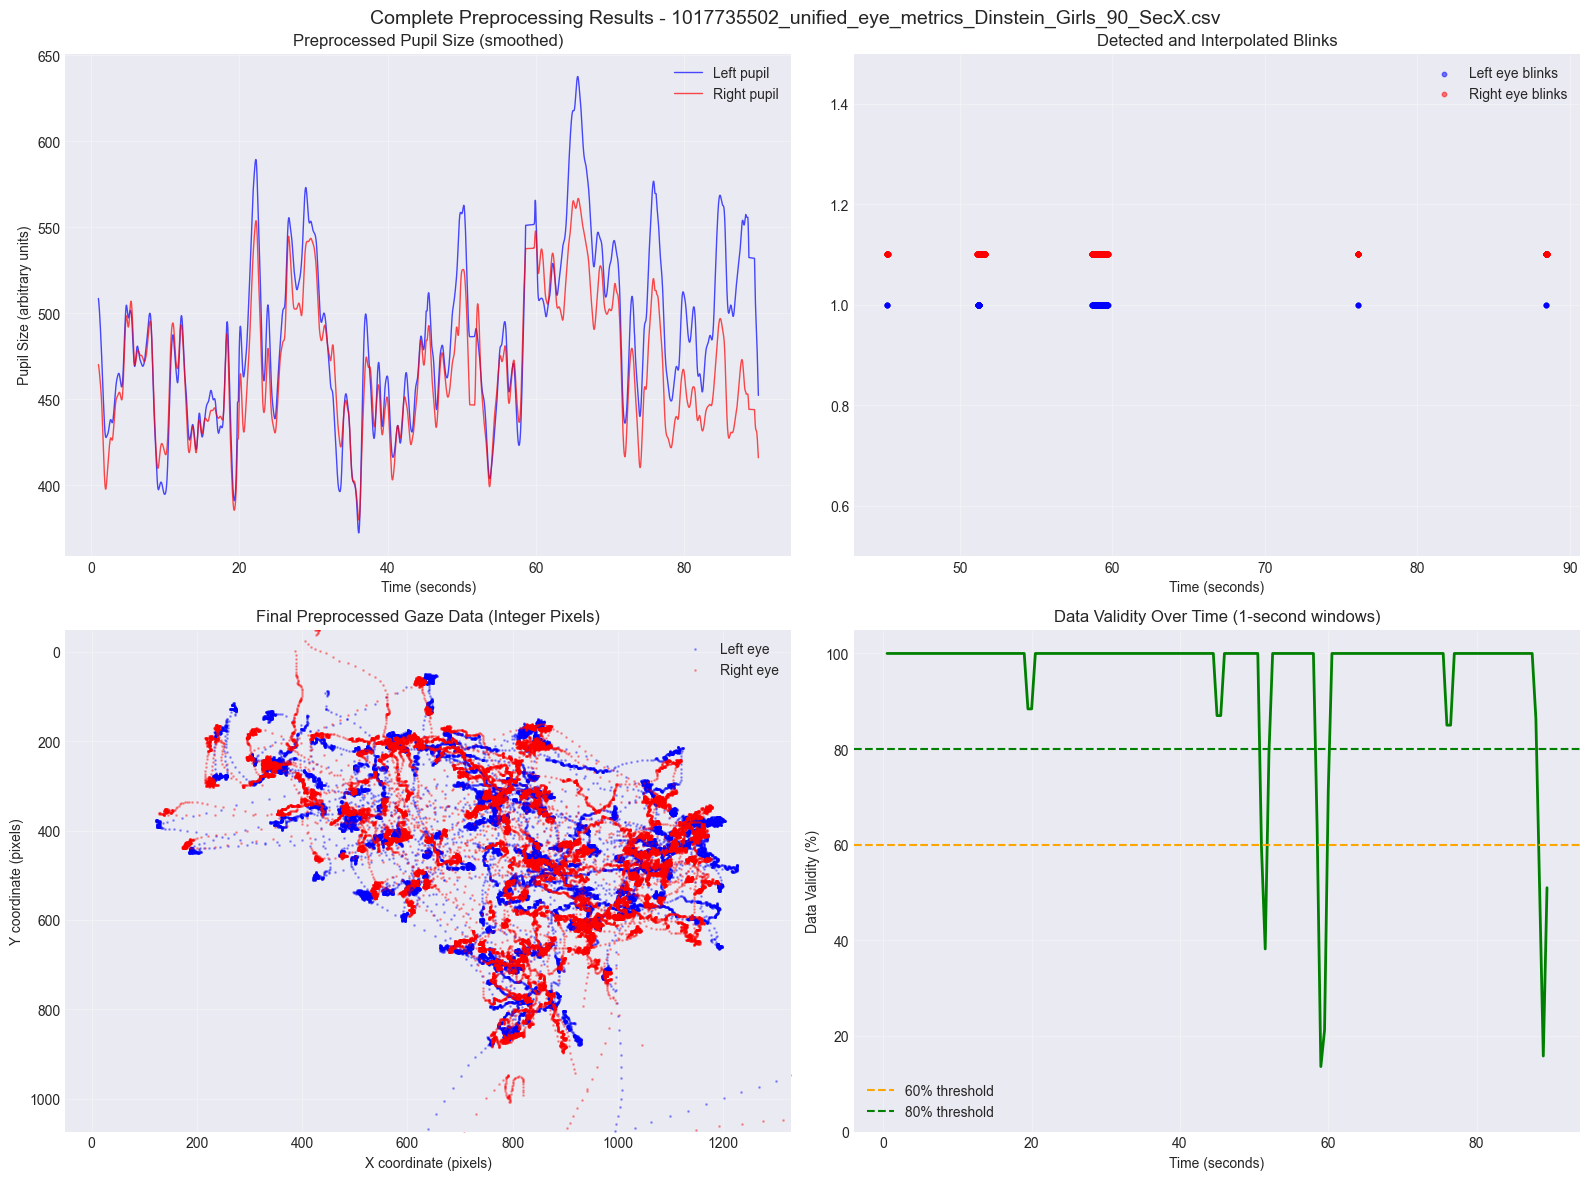


📊 Detailed Preprocessing Statistics:
Blink Statistics:
  Left eye: 1 blinks
  Right eye: 2 blinks

Pupil Preprocessing:
  pupil_left: 1.7% removed
  pupil_right: 1.4% removed


In [97]:
# Visualize the preprocessing results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Pupil size over time (smoothed)
ax = axes[0, 0]
valid_data = df_processed[df_processed['pupil_left'].notna()]
ax.plot(valid_data['time_seconds'], valid_data['pupil_left'], 
        color='blue', alpha=0.7, linewidth=1, label='Left pupil')
valid_data = df_processed[df_processed['pupil_right'].notna()]
ax.plot(valid_data['time_seconds'], valid_data['pupil_right'], 
        color='red', alpha=0.7, linewidth=1, label='Right pupil')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size (arbitrary units)')
ax.set_title('Preprocessed Pupil Size (smoothed)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Blink detection visualization
ax = axes[0, 1]
blink_left = df_processed[df_processed['is_blink_left']]
blink_right = df_processed[df_processed['is_blink_right']]
ax.scatter(blink_left['time_seconds'], np.ones(len(blink_left)), 
          color='blue', s=10, alpha=0.5, label='Left eye blinks')
ax.scatter(blink_right['time_seconds'], np.ones(len(blink_right))*1.1, 
          color='red', s=10, alpha=0.5, label='Right eye blinks')
ax.set_xlabel('Time (seconds)')
ax.set_ylim(0.5, 1.5)
ax.set_title('Detected and Interpolated Blinks')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Final gaze trajectory (integer pixels)
ax = axes[1, 0]
valid_data = df_processed[df_processed['both_eyes_valid']]
ax.scatter(valid_data['x_left'], valid_data['y_left'], 
          c='blue', alpha=0.3, s=1, label='Left eye')
ax.scatter(valid_data['x_right'], valid_data['y_right'], 
          c='red', alpha=0.3, s=1, label='Right eye')
ax.set_xlim(-50, SCREEN_WIDTH + 50)
ax.set_ylim(-50, SCREEN_HEIGHT + 50)
ax.invert_yaxis()
ax.set_xlabel('X coordinate (pixels)')
ax.set_ylabel('Y coordinate (pixels)')
ax.set_title('Final Preprocessed Gaze Data (Integer Pixels)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Data validity over time
ax = axes[1, 1]
window_size = 500  # 1 second windows
validity_over_time = []
time_points = []

for i in range(0, len(df_processed) - window_size, window_size//2):
    window = df_processed.iloc[i:i+window_size]
    validity_percent = window['both_eyes_valid'].sum() / len(window) * 100
    validity_over_time.append(validity_percent)
    time_points.append(window['time_seconds'].mean())

ax.plot(time_points, validity_over_time, 'g-', linewidth=2)
ax.axhline(y=60, color='orange', linestyle='--', label='60% threshold')
ax.axhline(y=80, color='green', linestyle='--', label='80% threshold')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Data Validity (%)')
ax.set_title('Data Validity Over Time (1-second windows)')
ax.set_ylim(0, 105)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'Complete Preprocessing Results - {info["file"]}', fontsize=14)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n📊 Detailed Preprocessing Statistics:")
print("="*50)
print(f"Blink Statistics:")
print(f"  Left eye: {info['blink_stats']['left_eye']['natural_blinks']} blinks")
print(f"  Right eye: {info['blink_stats']['right_eye']['natural_blinks']} blinks")
print(f"\nPupil Preprocessing:")
for eye, stats in info['pupil_stats'].items():
    if stats['original_valid'] > 0:
        print(f"  {eye}: {stats['removal_percentage']:.1f}% removed")

## 13. Pupil Size: Before vs After Preprocessing

Let's visualize the pupil size data before and after preprocessing to see the effects of our cleaning steps:

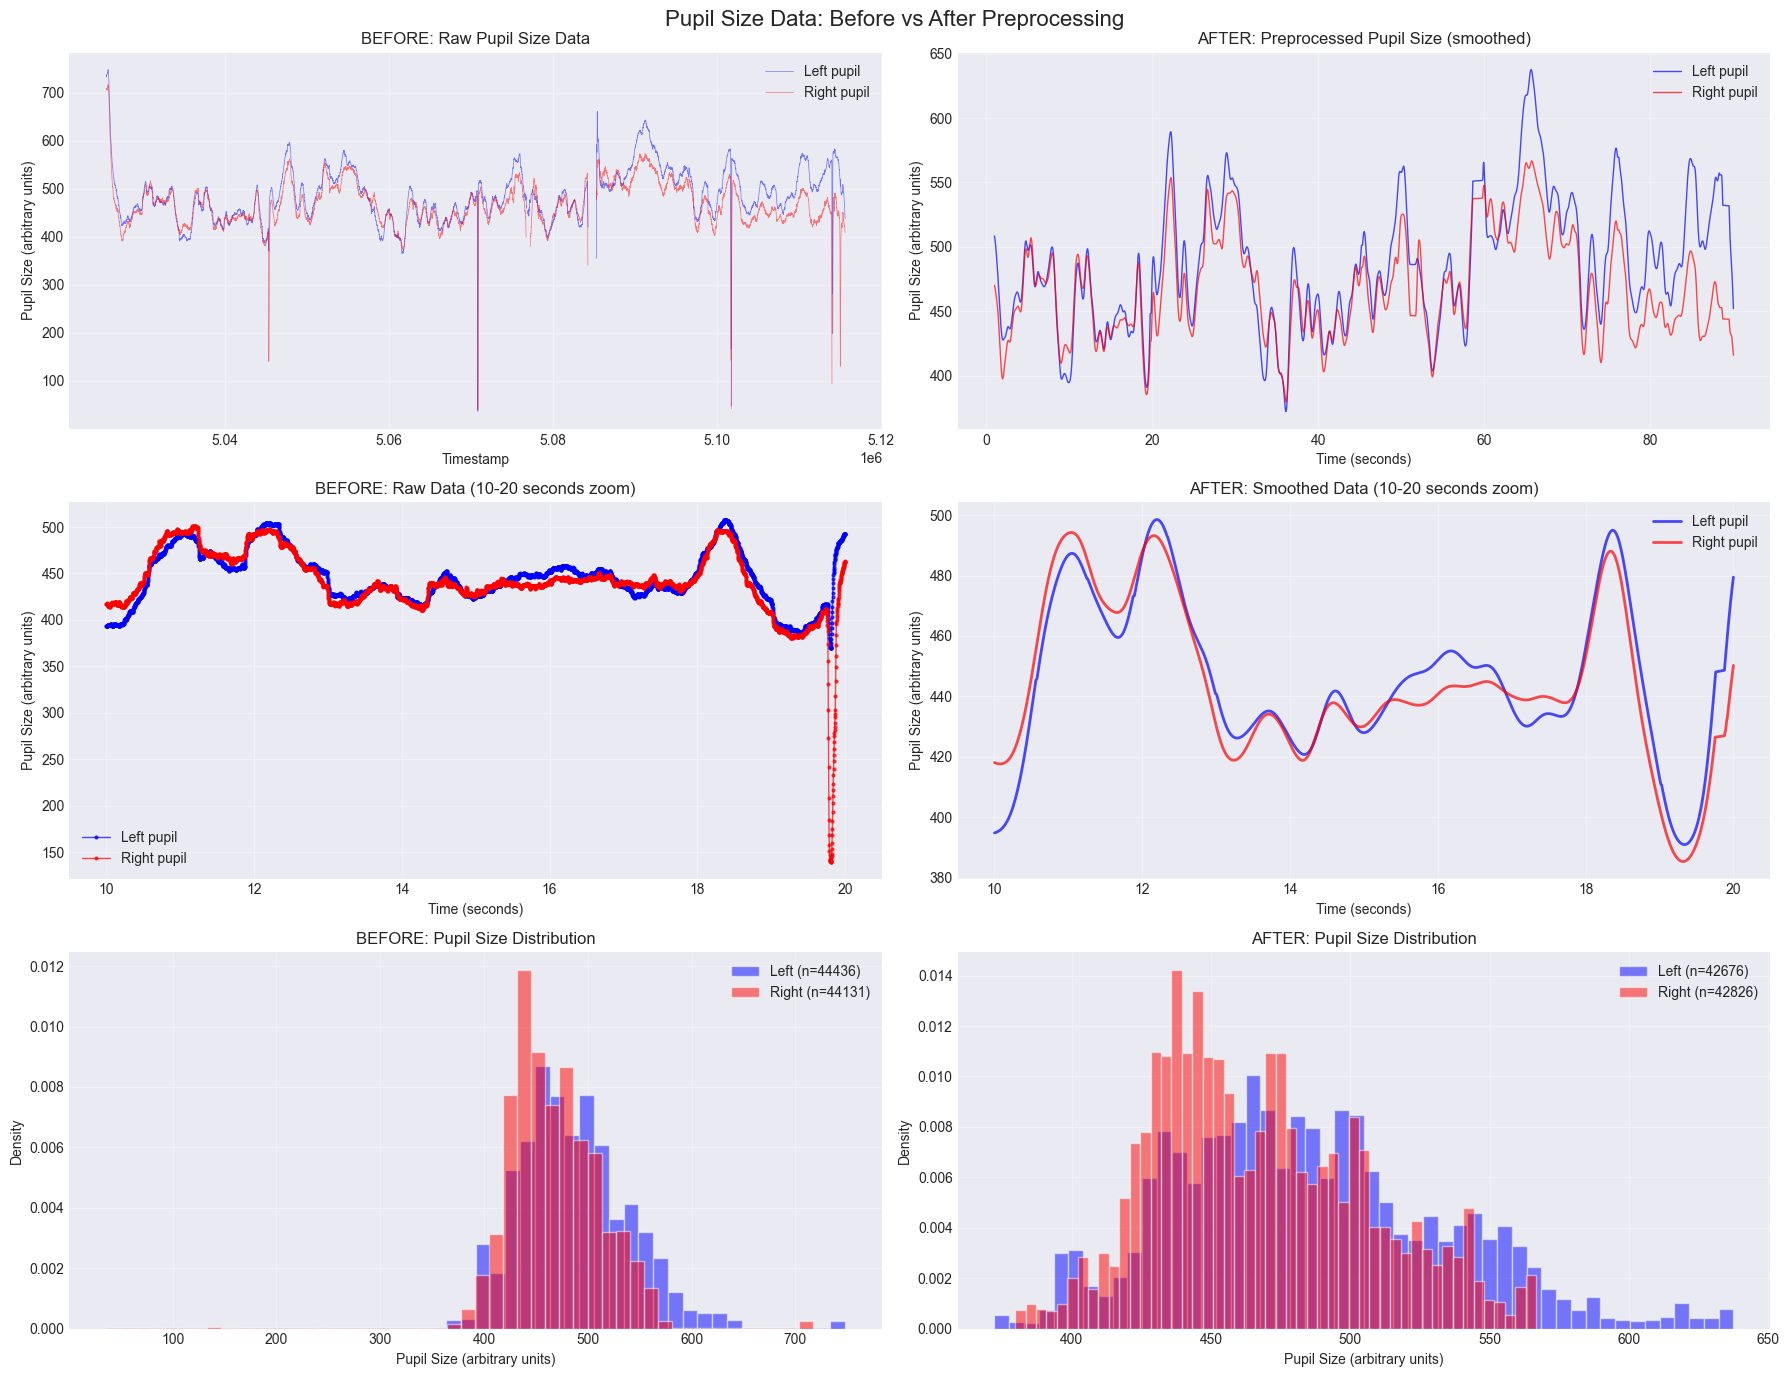

📊 Pupil Size Statistics Comparison
Metric                    Before (Left)   After (Left)    Before (Right)  After (Right)  
------------------------------------------------------------
Valid samples             44,436          42,676          44,131          42,826         
Mean                      486.8           485.0           467.6           467.5          
Std deviation             55.1            49.1            46.8            38.5           
Min                       36.0            372.2           38.0            379.6          
Max                       748.0           637.6           717.0           566.7          
5th percentile            406.0           408.9           409.0           413.0          
95th percentile           578.0           568.5           542.0           540.3          


In [98]:
# Load original data for comparison
df_original = pd.read_csv(csv_files[0])

# Create figure with subplots for before/after comparison
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# --- ROW 1: Raw vs Processed Full Time Series ---
# Before preprocessing
ax = axes[0, 0]
ax.plot(df_original['timestamp'], df_original['pupil_left'], 
        color='blue', alpha=0.5, linewidth=0.5, label='Left pupil')
ax.plot(df_original['timestamp'], df_original['pupil_right'], 
        color='red', alpha=0.5, linewidth=0.5, label='Right pupil')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Pupil Size (arbitrary units)')
ax.set_title('BEFORE: Raw Pupil Size Data')
ax.legend()
ax.grid(True, alpha=0.3)

# After preprocessing
ax = axes[0, 1]
valid_data = df_processed[df_processed['pupil_left'].notna()]
ax.plot(valid_data['time_seconds'], valid_data['pupil_left'], 
        color='blue', alpha=0.7, linewidth=1, label='Left pupil')
valid_data = df_processed[df_processed['pupil_right'].notna()]
ax.plot(valid_data['time_seconds'], valid_data['pupil_right'], 
        color='red', alpha=0.7, linewidth=1, label='Right pupil')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size (arbitrary units)')
ax.set_title('AFTER: Preprocessed Pupil Size (smoothed)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- ROW 2: Zoomed in view (10-20 seconds) ---
# Calculate time in seconds for original data
time_seconds_orig = (df_original['timestamp'] - df_original['timestamp'].iloc[0]) / 1000

# Before preprocessing (zoomed)
ax = axes[1, 0]
mask = (time_seconds_orig >= 10) & (time_seconds_orig <= 20)
ax.plot(time_seconds_orig[mask], df_original.loc[mask, 'pupil_left'], 
        'b-', alpha=0.7, linewidth=1, label='Left pupil', marker='o', markersize=2)
ax.plot(time_seconds_orig[mask], df_original.loc[mask, 'pupil_right'], 
        'r-', alpha=0.7, linewidth=1, label='Right pupil', marker='o', markersize=2)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size (arbitrary units)')
ax.set_title('BEFORE: Raw Data (10-20 seconds zoom)')
ax.legend()
ax.grid(True, alpha=0.3)

# After preprocessing (zoomed)
ax = axes[1, 1]
mask = (df_processed['time_seconds'] >= 10) & (df_processed['time_seconds'] <= 20)
valid_left = df_processed[mask & df_processed['pupil_left'].notna()]
valid_right = df_processed[mask & df_processed['pupil_right'].notna()]
ax.plot(valid_left['time_seconds'], valid_left['pupil_left'], 
        'b-', alpha=0.7, linewidth=2, label='Left pupil')
ax.plot(valid_right['time_seconds'], valid_right['pupil_right'], 
        'r-', alpha=0.7, linewidth=2, label='Right pupil')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size (arbitrary units)')
ax.set_title('AFTER: Smoothed Data (10-20 seconds zoom)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- ROW 3: Distribution and Statistics ---
# Before preprocessing - distribution
ax = axes[2, 0]
left_orig = df_original['pupil_left'].dropna()
right_orig = df_original['pupil_right'].dropna()
ax.hist(left_orig, bins=50, alpha=0.5, color='blue', label=f'Left (n={len(left_orig)})', density=True)
ax.hist(right_orig, bins=50, alpha=0.5, color='red', label=f'Right (n={len(right_orig)})', density=True)
ax.set_xlabel('Pupil Size (arbitrary units)')
ax.set_ylabel('Density')
ax.set_title('BEFORE: Pupil Size Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# After preprocessing - distribution
ax = axes[2, 1]
left_proc = df_processed['pupil_left'].dropna()
right_proc = df_processed['pupil_right'].dropna()
ax.hist(left_proc, bins=50, alpha=0.5, color='blue', label=f'Left (n={len(left_proc)})', density=True)
ax.hist(right_proc, bins=50, alpha=0.5, color='red', label=f'Right (n={len(right_proc)})', density=True)
ax.set_xlabel('Pupil Size (arbitrary units)')
ax.set_ylabel('Density')
ax.set_title('AFTER: Pupil Size Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Pupil Size Data: Before vs After Preprocessing', fontsize=16)
plt.tight_layout()
plt.show()

# Print statistics comparison
print("📊 Pupil Size Statistics Comparison")
print("="*60)
print(f"{'Metric':<25} {'Before (Left)':<15} {'After (Left)':<15} {'Before (Right)':<15} {'After (Right)':<15}")
print("-"*60)
print(f"{'Valid samples':<25} {len(left_orig):<15,} {len(left_proc):<15,} {len(right_orig):<15,} {len(right_proc):<15,}")
print(f"{'Mean':<25} {left_orig.mean():<15.1f} {left_proc.mean():<15.1f} {right_orig.mean():<15.1f} {right_proc.mean():<15.1f}")
print(f"{'Std deviation':<25} {left_orig.std():<15.1f} {left_proc.std():<15.1f} {right_orig.std():<15.1f} {right_proc.std():<15.1f}")
print(f"{'Min':<25} {left_orig.min():<15.1f} {left_proc.min():<15.1f} {right_orig.min():<15.1f} {right_proc.min():<15.1f}")
print(f"{'Max':<25} {left_orig.max():<15.1f} {left_proc.max():<15.1f} {right_orig.max():<15.1f} {right_proc.max():<15.1f}")
print(f"{'5th percentile':<25} {left_orig.quantile(0.05):<15.1f} {left_proc.quantile(0.05):<15.1f} {right_orig.quantile(0.05):<15.1f} {right_proc.quantile(0.05):<15.1f}")
print(f"{'95th percentile':<25} {left_orig.quantile(0.95):<15.1f} {left_proc.quantile(0.95):<15.1f} {right_orig.quantile(0.95):<15.1f} {right_proc.quantile(0.95):<15.1f}")

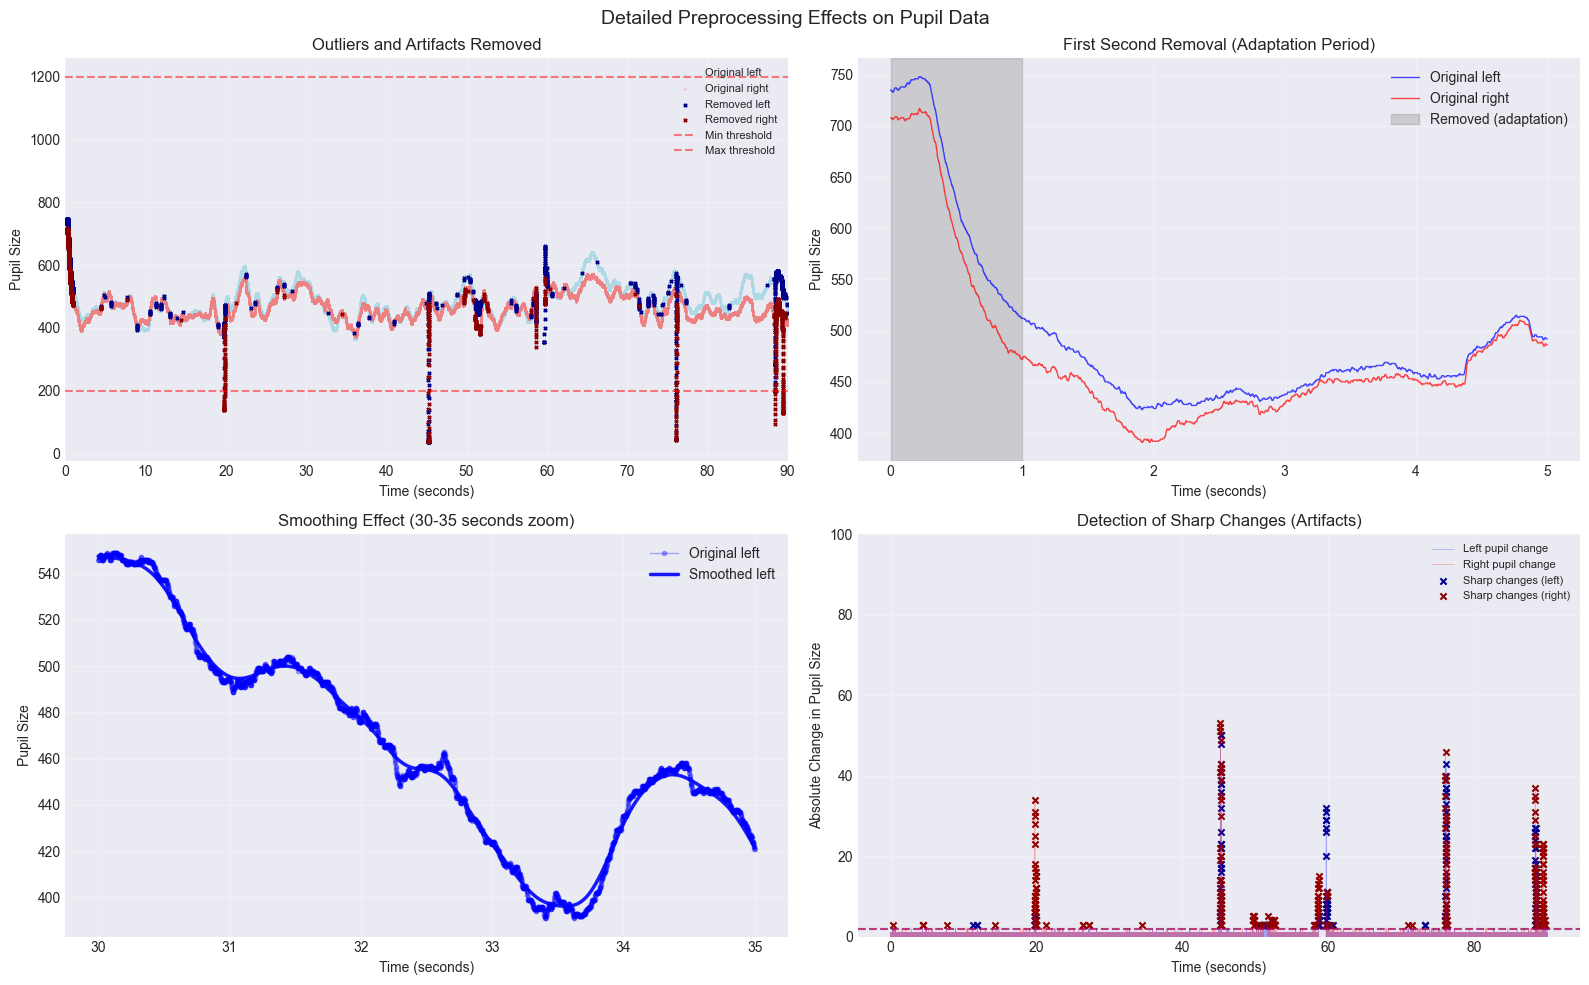


📋 Preprocessing Effects Summary
Original left pupil samples: 44,436
Original right pupil samples: 44,131

Removed by preprocessing:
  Left eye: 1,760 samples
  Right eye: 1,305 samples

Artifacts detected:
  Zero values: 0
  Below threshold (<200): 146
  Above threshold (>1200): 0
  Sharp changes (>99th percentile): 596


In [99]:
# Create a more detailed view of preprocessing effects
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Show outliers and artifacts removed
ax = axes[0, 0]
# Mark removed samples
removed_left = (df_original['pupil_left'].notna()) & (df_processed['pupil_left'].isna())
removed_right = (df_original['pupil_right'].notna()) & (df_processed['pupil_right'].isna())

ax.scatter(time_seconds_orig, df_original['pupil_left'], 
          c='lightblue', alpha=0.3, s=1, label='Original left')
ax.scatter(time_seconds_orig, df_original['pupil_right'], 
          c='lightcoral', alpha=0.3, s=1, label='Original right')
ax.scatter(time_seconds_orig[removed_left], df_original.loc[removed_left, 'pupil_left'], 
          c='darkblue', s=5, label='Removed left', marker='x')
ax.scatter(time_seconds_orig[removed_right], df_original.loc[removed_right, 'pupil_right'], 
          c='darkred', s=5, label='Removed right', marker='x')
ax.axhline(y=200, color='red', linestyle='--', alpha=0.5, label='Min threshold')
ax.axhline(y=1200, color='red', linestyle='--', alpha=0.5, label='Max threshold')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size')
ax.set_title('Outliers and Artifacts Removed')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 90)

# 2. First second removal visualization
ax = axes[0, 1]
mask_first_5 = time_seconds_orig <= 5
ax.plot(time_seconds_orig[mask_first_5], df_original.loc[mask_first_5, 'pupil_left'], 
        'b-', alpha=0.7, linewidth=1, label='Original left')
ax.plot(time_seconds_orig[mask_first_5], df_original.loc[mask_first_5, 'pupil_right'], 
        'r-', alpha=0.7, linewidth=1, label='Original right')
ax.axvspan(0, 1, alpha=0.3, color='gray', label='Removed (adaptation)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size')
ax.set_title('First Second Removal (Adaptation Period)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Smoothing effect demonstration
ax = axes[1, 0]
# Show a 5-second window with high detail
mask_window = (time_seconds_orig >= 30) & (time_seconds_orig <= 35)
mask_window_proc = (df_processed['time_seconds'] >= 30) & (df_processed['time_seconds'] <= 35)

# Plot original with markers
orig_window = df_original[mask_window]
proc_window = df_processed[mask_window_proc]

ax.plot(time_seconds_orig[mask_window], orig_window['pupil_left'], 
        'b-', alpha=0.3, linewidth=1, marker='o', markersize=3, label='Original left')
ax.plot(proc_window['time_seconds'], proc_window['pupil_left'], 
        'b-', alpha=0.9, linewidth=2.5, label='Smoothed left')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Pupil Size')
ax.set_title('Smoothing Effect (30-35 seconds zoom)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Sharp changes detection
ax = axes[1, 1]
# Calculate differences
left_diff = df_original['pupil_left'].diff().abs()
right_diff = df_original['pupil_right'].diff().abs()

# Find sharp changes
threshold_left = left_diff.quantile(0.99)
threshold_right = right_diff.quantile(0.99)
sharp_left = left_diff > threshold_left
sharp_right = right_diff > threshold_right

ax.plot(time_seconds_orig, left_diff, 'b-', alpha=0.3, linewidth=0.5, label='Left pupil change')
ax.plot(time_seconds_orig, right_diff, 'r-', alpha=0.3, linewidth=0.5, label='Right pupil change')
ax.scatter(time_seconds_orig[sharp_left], left_diff[sharp_left], 
          c='darkblue', s=20, marker='x', label='Sharp changes (left)')
ax.scatter(time_seconds_orig[sharp_right], right_diff[sharp_right], 
          c='darkred', s=20, marker='x', label='Sharp changes (right)')
ax.axhline(y=threshold_left, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=threshold_right, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Absolute Change in Pupil Size')
ax.set_title('Detection of Sharp Changes (Artifacts)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.suptitle('Detailed Preprocessing Effects on Pupil Data', fontsize=14)
plt.tight_layout()
plt.show()

# Print preprocessing effect summary
print("\n📋 Preprocessing Effects Summary")
print("="*60)
print(f"Original left pupil samples: {df_original['pupil_left'].notna().sum():,}")
print(f"Original right pupil samples: {df_original['pupil_right'].notna().sum():,}")
print(f"\nRemoved by preprocessing:")
print(f"  Left eye: {df_original['pupil_left'].notna().sum() - df_processed['pupil_left'].notna().sum():,} samples")
print(f"  Right eye: {df_original['pupil_right'].notna().sum() - df_processed['pupil_right'].notna().sum():,} samples")
print(f"\nArtifacts detected:")
print(f"  Zero values: {(df_original['pupil_left'] == 0).sum() + (df_original['pupil_right'] == 0).sum()}")
print(f"  Below threshold (<200): {((df_original['pupil_left'] < 200) & (df_original['pupil_left'] > 0)).sum() + ((df_original['pupil_right'] < 200) & (df_original['pupil_right'] > 0)).sum()}")
print(f"  Above threshold (>1200): {(df_original['pupil_left'] > 1200).sum() + (df_original['pupil_right'] > 1200).sum()}")
print(f"  Sharp changes (>99th percentile): {sharp_left.sum() + sharp_right.sum()}")

In [100]:
# Create a comprehensive preprocessing function for batch processing
def preprocess_eye_tracking_data(file_path, verbose=True):
    """
    Complete preprocessing pipeline for eye-tracking data.

    Args:
        file_path: Path to CSV file
        verbose: Print progress messages

    Returns:
        df_final: Cleaned dataframe
        stats: Dictionary with preprocessing statistics
    """
    if verbose:
        print(f"\nProcessing: {os.path.basename(file_path)}")
        print("="*50)

    # Load data
    df = pd.read_csv(file_path)
    initial_samples = len(df)

    # Remove empty columns
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    cols_to_remove = missing_percentage[missing_percentage > 95].index.tolist()
    df = df.drop(columns=cols_to_remove)

    # Add helper features
    add_cleaning_help_features(df)

    # Enforce binocular validity
    df = enforce_binocular_validity(df)
    binocular_samples = df['both_eyes_valid'].sum()

    # Apply calibration correction
    df, correction_info = automatic_binocular_calibration(df, verbose=False)

    # Remove extreme disparities
    df = remove_extreme_disparities(df, max_disparity=150)
    final_samples = df['both_eyes_valid'].sum()

    # Calculate statistics
    stats = {
        'initial_samples': initial_samples,
        'binocular_samples': binocular_samples,
        'final_samples': final_samples,
        'retention_rate': final_samples / initial_samples * 100,
        'calibration_correction': correction_info
    }

    if verbose:
        print(f"\n✓ Preprocessing complete!")
        print(f"  Initial: {initial_samples:,} → Final: {final_samples:,} ({stats['retention_rate']:.1f}%)")

    return df, stats

# Example usage
df_final, preprocessing_stats = preprocess_eye_tracking_data(sample_file)


Processing: 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
Found 305 monocular samples (0.7%)
After enforcement: 44131 valid binocular samples (98.1%)
Found 696 samples with extreme disparity (>150 pixels)
That's 1.58% of previously valid data

Found 0 samples far outside screen bounds (margin=500px)

After filtering: 43435 valid samples (96.5%)

✓ Preprocessing complete!
  Initial: 45,007 → Final: 43,435 (96.5%)
